<H3>PRI 2023/24: second
    project delivery</H3>

**GROUP 11**
- Francisco Martins, 99068
- Tunahan Güneş, 108108
- Sebastian Weidinger, 111612

In [1]:
from transformers import DistilBertTokenizer, DistilBertModel
from G11_code.data_collection import *
from G11_code.helper_functions import *
from G11_code.indexing import *
from G11_code.evaluation import *
from G11_code.clustering import *
from G11_code.supervised_classification import *

/home/mono/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-03-28 11:08:40.524529: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-28 11:08:40.524583: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-28 11:08:40.525712: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-28 11:08:40.531383: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimi

In [2]:
article_path = os.path.join("..", "BBC News Summary", "BBC News Summary", "News Articles")
summary_path = os.path.join("..", "BBC News Summary", "BBC News Summary", "Summaries")
print("Article path:", article_path)
print("Summary path:", summary_path)
_article_file_paths_by_cat, _articles_by_cat, _summary_file_paths_by_cat, _summaries_by_cat, category_names = read_files(article_path, summary_path)

Article path: ../BBC News Summary/BBC News Summary/News Articles
Summary path: ../BBC News Summary/BBC News Summary/Summaries
Number of Categories: 5
Number of Articles in 'tech' Category: 510
Number of Articles in 'entertainment' Category: 386
Number of Articles in 'sport' Category: 417
Number of Articles in 'business' Category: 511
Number of Articles in 'politics' Category: 401


In [3]:
_summary_sentence_indices_by_cat, faulty_summary_ids = get_summary_sentence_indices(_articles_by_cat, _summaries_by_cat)

number of found summaries: 2220
number of summaries: 2225
99.78%


In [4]:
articles_by_cat = remove_entries(_articles_by_cat, faulty_summary_ids)
articles = flatten(articles_by_cat)
article_file_paths_by_cat = remove_entries(_article_file_paths_by_cat, faulty_summary_ids)
article_file_paths = flatten(article_file_paths_by_cat)
summaries_by_cat = remove_entries(_summaries_by_cat, faulty_summary_ids)
summaries = flatten(summaries_by_cat)
summary_file_paths_by_cat = remove_entries(_summary_file_paths_by_cat, faulty_summary_ids)
summary_file_paths = flatten(summary_file_paths_by_cat)
summary_sentence_indices_by_cat = remove_entries(_summary_sentence_indices_by_cat, faulty_summary_ids)
summary_sentence_indices = flatten(summary_sentence_indices_by_cat)

In [5]:
dict_path_to_articleID = {path:i for i, path in enumerate(article_file_paths)}
def map_path_to_articleID(path):
    path = os.path.normpath(path)
    return dict_path_to_articleID.get(path)

In [6]:
I = indexing(articles)

In [7]:
path = os.path.join(article_path, 'tech', '199.txt')
d = map_path_to_articleID(path)

Document id=2017 → vocabulary and term frequencies:
+-------------------------------------+------+--------+--------------------------------------------------------------------------------------------------+
|             Vocabulary              | DF_t | TF_d_t |                                           TF/sentence                                            |
+-------------------------------------+------+--------+--------------------------------------------------------------------------------------------------+
|                month                | 577  |   2    |                                        [(28, 1), (34, 1)]                                        |
|                 one                 | 1042 |   6    |                      [(3, 1), (13, 1), (16, 1), (20, 1), (23, 1), (24, 1)]                       |
|              internet               | 163  |   1    |                                             [(4, 1)]                                             |
|             conn

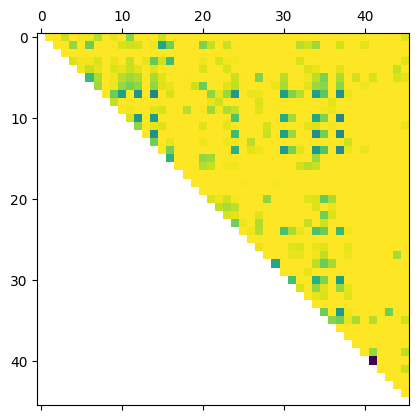

In [8]:
print(I.doc_to_string(d))
dissimilarity_matrix_tfidf = tf_idf_compute_dissimilarity_matrix(d, I)
plt.matshow(dissimilarity_matrix_tfidf)

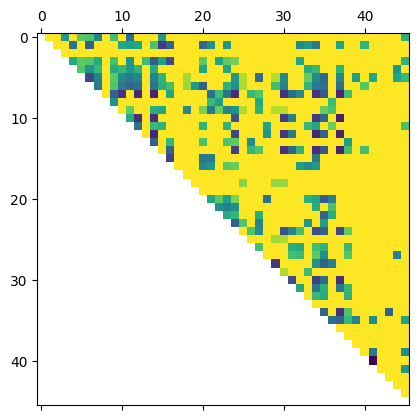

In [9]:
# If using another function to map the similarity matrix into a dissimilarity matrix such as d_ij = (1-s_ij^0.5)^2
plt.matshow((1-np.power(1 - dissimilarity_matrix_tfidf, 1/2))**2)

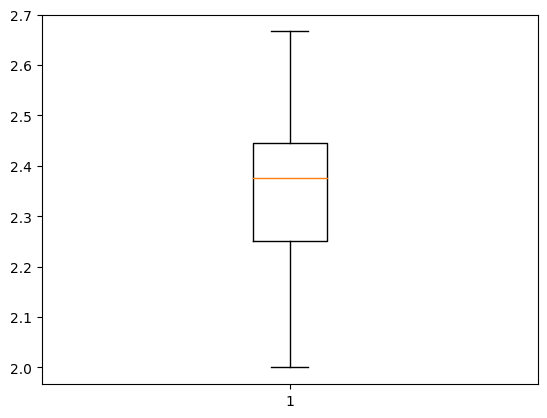

In [10]:
ratios = np.array([len(nltk.sent_tokenize(articles[i]))/len(summary_sentence_indices[i]) for i in range(len(articles))])
plt.boxplot(ratios)
None

In [11]:
pretrained_weights = 'distilbert-base-uncased'
bert_tokenizer = DistilBertTokenizer.from_pretrained(pretrained_weights, do_lower_case=True)
bert_model = DistilBertModel.from_pretrained(pretrained_weights)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bert_model.to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


/home/mono/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0): TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(i

In [12]:
sentence_embeddings_path = './embeddings/sentence_embeddings.pkl'
bert_params = (bert_tokenizer, bert_model, device)
dissimilarity_matrix_bert = bert_compute_dissimilarity_matrix(0, articles, bert_params, sentence_embeddings_path)

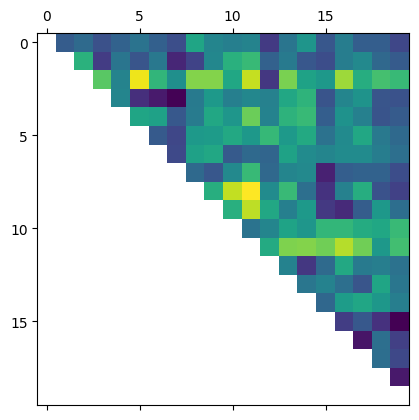

In [13]:
plt.matshow(dissimilarity_matrix_bert)

In [14]:
# print two closest sentences according to bert
for d in (0, 10, 600, 610, 900, 910):
    bert_params = (bert_tokenizer, bert_model, device)
    dissimilarity_matrix_bert = bert_compute_dissimilarity_matrix(d, articles, bert_params)
    index_closest_bert = np.argmin(dissimilarity_matrix_bert)
    tokenized_article = nltk.sent_tokenize(articles[d])
    num_sent = len(tokenized_article)
    sent1 = index_closest_bert//num_sent
    sent2 = index_closest_bert%num_sent
    print(tokenized_article[sent1])
    print(tokenized_article[sent2])
    print(dissimilarity_matrix_bert[sent1, sent2])
    print('---')

TimeWarner is to restate its accounts as part of efforts to resolve an inquiry into AOL by US market regulators.
It will now book the sale of its stake in AOL Europe as a loss on the value of that stake.
0.028776646
---
The firm's revenue nearly tripled in the fourth quarter of 2004, exceeding $86m (£46m).
But on Thursday, it announced that a sharp turnaround had brought about an unexpected increase in profits.
0.03652972
---
Unusually, the runners-up in categories were also named with Clint Eastwood's Million Dollar Baby just missing out on the best film award.
The best director runner-up was Martin Scorsese for The Aviator.
0.03291732
---
Twelve films competing in the new world cinema documentary category focus on countries and people under siege.
The 16 films competing in the new world cinema dramatic category include works from Germany, South Korea, Angola, China, Denmark and Australia.
0.024558902
---


Prof Joni Lovenduski, who conducted the study with the help of Margaret Moran MP and a team of journalists, said she was shocked at the findings.
This was mainly because there were more women present in Parliament who were not prepared to "put up with" the sexist attitudes they came across, Prof Lovenduski said.
0.037931204
---
Between 1.1 and 1.5 million people, mainly Jews, were killed at Auschwitz.
Altogether, some six million people, mainly Jews, perished in the Holocaust.
0.03375292
---


In [15]:
# print two closest sentences according to tfidf
for d in (0, 10, 600, 610, 900, 910):
    dissimilarity_matrix_tfidf = tf_idf_compute_dissimilarity_matrix(d, I)
    index_closest_tfidf = np.argmin(dissimilarity_matrix_tfidf)
    tokenized_article = nltk.sent_tokenize(articles[d])
    num_sent = len(tokenized_article)
    sent1 = index_closest_tfidf//num_sent
    sent2 = index_closest_tfidf%num_sent
    print(tokenized_article[sent1])
    print(tokenized_article[sent2])
    print(dissimilarity_matrix_tfidf[sent1, sent2])
    print('---')

It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters.
Time Warner's fourth quarter profits were slightly better than analysts' expectations.
0.5712966777812147
---
Ask Jeeves has become the third leading online search firm this week to thank a revival in internet advertising for improving fortunes.
Late last year, marketing company Doubleclick, one of the leading providers of online advertising, warned that some or all of its business would have to be put up for sale.
0.7983408935807431
---
The awards will be handed out on 13 January at a ceremony in Las Vegas.
A career achievement award will be handed to veteran actor and comic Jerry Lewis at the ceremony next year.
0.765904440541825
---
Twelve films competing in the new world cinema documentary category focus on countries and people under siege.
The 16 films competing in the new world cinema dramatic category include works from Germany, South Korea, Angola, China, Denmark and Austr

In [16]:
# save sentence and document embeddings 
pretrained_weights = 'distilbert-base-uncased'
bert_tokenizer = DistilBertTokenizer.from_pretrained(pretrained_weights, do_lower_case=True)
bert_model = DistilBertModel.from_pretrained(pretrained_weights)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bert_model.to(device)
path = './embeddings'
if not os.listdir(path): 
    save_embeddings(articles, bert_tokenizer, bert_model, device, path)
else: 
    print(f'Files exist in folder {path}')

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Files exist in folder ./embeddings


In [17]:
# load embeddings 
sentence_embeddings_path = os.path.join('./embeddings', 'sentence_embeddings.pkl')
sentence_embeddings_by_cat = pickle_load(sentence_embeddings_path)
document_embeddings_path = os.path.join('./embeddings', 'document_embeddings.pkl')
document_embeddings_by_cat = pickle_load(document_embeddings_path)

In [18]:
from G11_code.training import *

train_emb_by_cat, test_emb_by_cat, train_ind_by_cat, test_ind_by_cat = split_by_cat(sentence_embeddings_by_cat, summary_sentence_indices_by_cat)

X_train, Y_train = get_XY(train_emb_by_cat, train_ind_by_cat)
X_test, Y_test = get_XY(test_emb_by_cat, test_ind_by_cat)
X_train = flatten(X_train)
X_test = flatten(X_test)
Y_train = flatten(Y_train)
Y_test = flatten(Y_test)

In [19]:
n_components = 200

Number of Articles in 'tech' Category: 510
Number of Articles in 'entertainment' Category: 386
Number of Articles in 'sport' Category: 417
Number of Articles in 'business' Category: 511
Number of Articles in 'politics' Category: 401

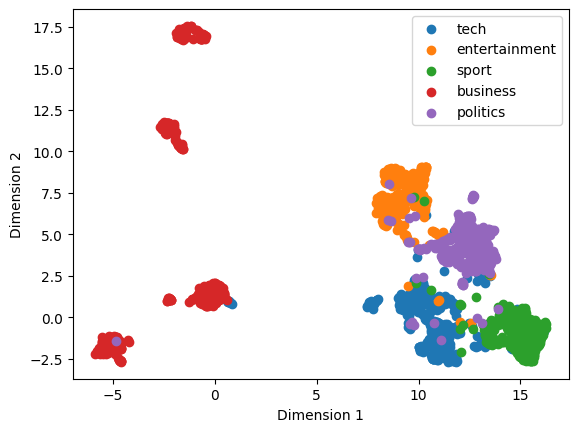

In [20]:
# visualize documents by category
categories = ['tech', 'entertainment', 'sport', 'business', 'politics']
all_doc_emb = flatten(flatten(document_embeddings_by_cat))
#reducer = fit_UMAP(X_train, n_components=2)
reducer = fit_UMAP(all_doc_emb, n_components=2)
for i, cat in enumerate(document_embeddings_by_cat): 
    samples = np.array(flatten(cat)) 
    #idx = np.random.randint(samples.shape[0], size=100)
    #samples = samples[idx,:]
    X_train_trans = transform_UMAP(reducer, samples)
    plt.scatter(X_train_trans[:,0], X_train_trans[:,1], label=categories[i])
plt.legend(categories)
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()
#X_test_trans = transform_UMAP(reducer, X_test)

In [21]:
pca = fit_PCA(X_train, n_components=n_components)
X_train_trans = transform_PCA(pca, X_train)
X_test_trans = transform_PCA(pca, X_test)

In [22]:
from sklearn.metrics import accuracy_score, classification_report

xgb_model = training(train_emb_by_cat, train_ind_by_cat, model_name="XGBoost", use_pca=True, n_components=n_components)

              precision    recall  f1-score   support

           0       0.62      0.75      0.68      4970
           1       0.52      0.37      0.43      3609

    accuracy                           0.59      8579
   macro avg       0.57      0.56      0.55      8579
weighted avg       0.58      0.59      0.57      8579

In [23]:
predictions = xgb_model.predict(X_test_trans)
accuracy = accuracy_score(Y_test, predictions)
print(classification_report(Y_test, predictions))

              precision    recall  f1-score   support

           0       0.60      0.72      0.65      4970
           1       0.46      0.32      0.38      3609

    accuracy                           0.56      8579
   macro avg       0.53      0.52      0.52      8579
weighted avg       0.54      0.56      0.54      8579



In [24]:
precision, recall, auc = supervised_evaluation(test_emb_by_cat, test_ind_by_cat, xgb_model, model_name="XGBoost", use_pca=True, X_train=X_train, n_components=n_components)
#precision, recall, auc = supervised_evaluation(test_emb_by_cat, test_ind_by_cat, model, model_name="XGBoost")
print(f'Classifier XGBoost - Precision: {precision} | Recall: {recall} | AUC: {auc}')

Classifier XGBoost - Precision: 0.4684014869888476 | Recall: 0.3491271820448878 | AUC: 0.5307004119479972


In [25]:
if os.listdir('./nn_model/'):
    nn_model = NNModel(n_components)
    nn_model.load_weights('./nn_model/final_model')
else:
    nn_model = training(train_emb_by_cat, train_ind_by_cat, model_name="NN", use_pca=True, n_components=n_components)
predictions = np.round(nn_model.predict(X_test_trans)).astype(int)
print(classification_report(Y_test, predictions))

  1/269 [..............................] - ETA: 32s

2024-03-28 11:09:58.009884: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-03-28 11:09:58.009944: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: mono-laptop
2024-03-28 11:09:58.009957: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: mono-laptop
2024-03-28 11:09:58.010240: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: NOT_FOUND: was unable to find libcuda.so DSO loaded into this program
2024-03-28 11:09:58.010302: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 535.161.7


269/269 [==============================] - 0s 465us/step
              precision    recall  f1-score   support

           0       0.58      0.56      0.57      4970
           1       0.43      0.45      0.44      3609

    accuracy                           0.51      8579
   macro avg       0.51      0.51      0.51      8579
weighted avg       0.52      0.51      0.52      8579



In [26]:
precision, recall, auc = supervised_evaluation(test_emb_by_cat, test_ind_by_cat, nn_model, model_name="NN", use_pca=True, X_train=X_train, n_components=n_components)
print(f'Classifier NN - Precision: {precision} | Recall: {recall} | AUC: {auc}')

269/269 [==============================] - 0s 462us/step
Classifier NN - Precision: 0.4292591602032629 | Recall: 0.44472152950955945 | AUC: 0.5076726359821438


In [27]:
if not os.listdir('./nn_model'):
    nn_model.save_weights('./nn_model/final_model')

In [28]:
if os.listdir('./lstm_model/'):
    lstm_model = LSTMModel(128, n_components)
    lstm_model.load_weights('./lstm_model/final_model')
else:
    lstm_model = training(train_emb_by_cat, train_ind_by_cat, model_name="LSTM", use_pca=True, n_components=n_components)

In [31]:
if not os.listdir('./lstm_model'):
    lstm_model.save_weights('./lstm_model/final_model')

In [30]:
precision, recall, auc = supervised_evaluation(test_emb_by_cat, test_ind_by_cat, lstm_model, model_name="LSTM", use_pca=True, X_train=X_train, n_components=n_components)
print(f'Classifier LSTM - Precision: {precision} | Recall: {recall} | AUC: {auc}')

Classifier LSTM - Precision: 0.4256198347107438 | Recall: 0.42809642560266004 | AUC: 0.504289661493483


In [32]:
'''
X_test, y_test = get_XY(test_emb_by_cat, test_ind_by_cat)
X_test_trans = [transform_PCA(pca, x) for x in X_test]
all_predictions = list()
all_ytest = np.array(flatten(y_test))
for X, y in zip(X_test_trans, y_test): 
    #X = np.array(transform_PCA(pca, X))
    X = np.array(X)
    X = np.expand_dims(X, axis=0)
    y = np.array(y)
    predictions = lstm_model.predict(X, verbose=0)
    predictions = np.round(predictions.squeeze()).astype(int)
    all_predictions.extend(predictions)
precision = sklearn.metrics.precision_score(all_ytest, all_predictions)
recall = sklearn.metrics.recall_score(all_ytest, all_predictions)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(all_ytest, all_predictions)  
auc = sklearn.metrics.auc(fpr, tpr)
   
print(precision)
print(recall)
print(auc)
print(classification_report(all_ytest, all_predictions))
'''

'\nX_test, y_test = get_XY(test_emb_by_cat, test_ind_by_cat)\nX_test_trans = [transform_PCA(pca, x) for x in X_test]\nall_predictions = list()\nall_ytest = np.array(flatten(y_test))\nfor X, y in zip(X_test_trans, y_test): \n    #X = np.array(transform_PCA(pca, X))\n    X = np.array(X)\n    X = np.expand_dims(X, axis=0)\n    y = np.array(y)\n    predictions = lstm_model.predict(X, verbose=0)\n    predictions = np.round(predictions.squeeze()).astype(int)\n    all_predictions.extend(predictions)\nprecision = sklearn.metrics.precision_score(all_ytest, all_predictions)\nrecall = sklearn.metrics.recall_score(all_ytest, all_predictions)\nfpr, tpr, thresholds = sklearn.metrics.roc_curve(all_ytest, all_predictions)  \nauc = sklearn.metrics.auc(fpr, tpr)\n   \nprint(precision)\nprint(recall)\nprint(auc)\nprint(classification_report(all_ytest, all_predictions))\n'

In [ ]:
'''
from keras.models import Sequential
from keras.layers import LSTM, TimeDistributed, Dense, Bidirectional, Dropout
from keras.metrics import Recall

LSTM_units = 32

model = Sequential()
model.add(Bidirectional(LSTM(units=LSTM_units, 
               input_shape=(None, n_components), 
               return_sequences=True)))
model.add(Dropout(0.1))
model.add(Bidirectional(LSTM(units=LSTM_units, return_sequences=True)))
model.add(Dropout(0.1))
model.add(Bidirectional(LSTM(units=LSTM_units, return_sequences=True)))
model.add(Dropout(0.1))
model.add(TimeDistributed(Dense(1, activation='sigmoid')))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["AUC"])
model.build(input_shape=(None, None, n_components))
print(model.summary())
'''

'\nfrom keras.models import Sequential\nfrom keras.layers import LSTM, TimeDistributed, Dense, Bidirectional, Dropout\nfrom keras.metrics import Recall\n\nLSTM_units = 32\n\nmodel = Sequential()\nmodel.add(Bidirectional(LSTM(units=LSTM_units, \n               input_shape=(None, n_components), \n               return_sequences=True)))\nmodel.add(Dropout(0.1))\nmodel.add(Bidirectional(LSTM(units=LSTM_units, return_sequences=True)))\nmodel.add(Dropout(0.1))\nmodel.add(Bidirectional(LSTM(units=LSTM_units, return_sequences=True)))\nmodel.add(Dropout(0.1))\nmodel.add(TimeDistributed(Dense(1, activation=\'sigmoid\')))\nmodel.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=["AUC"])\nmodel.build(input_shape=(None, None, n_components))\nprint(model.summary())\n'

In [34]:
'''
from itertools import groupby
X_train, Y_train = get_XY(train_emb_by_cat, train_ind_by_cat)
X_train_trans = [transform_PCA(pca, x) for x in X_train]
Y_train = [y for _, y in sorted(zip(X_train_trans, Y_train), key=lambda x: len(x[0]))]
X_train_trans.sort(key=len)
X_train_groups = [list(g) for k, g in groupby(X_train_trans, key=len)]
Y_train_groups = [list(g) for k, g in groupby(Y_train, key=len)]
'''

'\nfrom itertools import groupby\nX_train, Y_train = get_XY(train_emb_by_cat, train_ind_by_cat)\nX_train_trans = [transform_PCA(pca, x) for x in X_train]\nY_train = [y for _, y in sorted(zip(X_train_trans, Y_train), key=lambda x: len(x[0]))]\nX_train_trans.sort(key=len)\nX_train_groups = [list(g) for k, g in groupby(X_train_trans, key=len)]\nY_train_groups = [list(g) for k, g in groupby(Y_train, key=len)]\n'

In [33]:
'''
X_test, y_test = get_XY(test_emb_by_cat, test_ind_by_cat)
X_test_trans = [transform_PCA(pca, x) for x in X_test]

y_t = list()
all_predictions = list()
n = 100  # for 2 random indices
index = np.random.choice(len(X_test_trans), n, replace=False)
for k in index: 
    y_t.extend(y_test[k])

epochs = 100
for i in range(epochs):
    for X, y in zip(X_train_groups, Y_train_groups):
        X = np.array(X)
        X = X.reshape(len(X), len(X[0]), n_components)
        y = np.array(y)
        y = y.reshape(len(y), len(y[0]), 1)
        history = model.fit(X, y, epochs=1, batch_size=32, verbose=0, shuffle=True)
    avg_loss = np.mean(history.history['loss'][-100:])
    avg_auc = np.mean(history.history['auc'][-100:])

    all_predictions = list()
    for k in index: 
        x = X_test_trans[k]
        x = np.expand_dims(x, axis=0)
        predictions = model.predict(x, verbose=0)
        predictions = np.round(predictions.squeeze()).astype(int)
        all_predictions.extend(predictions)
    print(classification_report(y_t, all_predictions))
    print(f"Loss:{avg_loss} | AUC:{avg_auc}")
'''

'\nX_test, y_test = get_XY(test_emb_by_cat, test_ind_by_cat)\nX_test_trans = [transform_PCA(pca, x) for x in X_test]\n\ny_t = list()\nall_predictions = list()\nn = 100  # for 2 random indices\nindex = np.random.choice(len(X_test_trans), n, replace=False)\nfor k in index: \n    y_t.extend(y_test[k])\n\nepochs = 100\nfor i in range(epochs):\n    for X, y in zip(X_train_groups, Y_train_groups):\n        X = np.array(X)\n        X = X.reshape(len(X), len(X[0]), n_components)\n        y = np.array(y)\n        y = y.reshape(len(y), len(y[0]), 1)\n        history = model.fit(X, y, epochs=1, batch_size=32, verbose=0, shuffle=True)\n    avg_loss = np.mean(history.history[\'loss\'][-100:])\n    avg_auc = np.mean(history.history[\'auc\'][-100:])\n\n    all_predictions = list()\n    for k in index: \n        x = X_test_trans[k]\n        x = np.expand_dims(x, axis=0)\n        predictions = model.predict(x, verbose=0)\n        predictions = np.round(predictions.squeeze()).astype(int)\n        all_pr

<H2>Main facilities</H2>

<h3>Part I: clustering</h3>

*A) Clustering*

In [ ]:
#code, statistics and/or charts here

*B) Summarization*

In [ ]:
#code, statistics and/or charts here

*C) Keyword extraction*

In [ ]:
#code, statistics and/or charts here

*D) Evaluation*

In [ ]:
#code, statistics and/or charts here

<h3>Part II: classification</h3>

*A) Feature extraction*

In [ ]:
# load embeddings 
sentence_embeddings_path = os.path.join('./embeddings', 'sentence_embeddings.pkl')
sentence_embeddings_by_cat = pickle_load(sentence_embeddings_path)
sentence_embeddings = flatten(sentence_embeddings_by_cat)
document_embeddings_path = os.path.join('./embeddings', 'document_embeddings.pkl')
document_embeddings_by_cat = pickle_load(document_embeddings_path)
document_embeddings = flatten(document_embeddings_by_cat)

In [ ]:
doc_ids_by_cat = generate_doc_ids_cat()
X_train, y_train, X_test, y_test = construct_df_and_split(doc_ids_by_cat=doc_ids_by_cat,
                                                          summary_sentence_indices_by_cat=summary_sentence_indices_by_cat,
                                                          sent_embeddings=sentence_embeddings,
                                                          doc_embeddings=document_embeddings,
                                                          article_file_paths=article_file_paths,
                                                          articles=articles,
                                                          train_size=0.8,
                                                          k=0.2,
                                                          b=0.75,
                                                          p_keywords=10)
#X_train.to_csv('./dataframes/X_train.csv', index=False)
#np.save('./dataframes/y_train.npy', y_train)
#X_test.to_csv('./dataframes/X_test.csv', index=False)
#np.save('./dataframes/y_test.npy', y_test)

In [ ]:
X_train = pd.read_csv('./dataframes/X_train.csv')
y_train = np.load('./dataframes/y_train.npy')
X_test = pd.read_csv('./dataframes/X_test.csv')
y_test = np.load('./dataframes/y_test.npy')

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

#model = training(train_emb_by_cat, train_ind_by_cat, model_name="XGBoost", use_pca=True, n_components=n_components)
model = training(X_train, y_train, model_name="XGBoost", use_extracted_features=True)

predictions = model.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
print(classification_report(y_test, predictions))

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

#model = training(train_emb_by_cat, train_ind_by_cat, model_name="XGBoost", use_pca=True, n_components=n_components)
model = training(X_train, y_train, model_name="NN", use_extracted_features=True,use_val=True, X_val=X_test, y_val=y_test)

predictions = np.rint(model.predict(X_test))
precitions = np.squeeze(predictions)
accuracy = accuracy_score(y_test, predictions)
print(classification_report(y_test, predictions))

*B) Classification*

In [ ]:
#code here

*C) Ranking extension*

In [ ]:
#code here

*D) Evaluation*

In [ ]:
#code, statistics and/or charts here

<H2>Question materials (optional)</H2>

<H3>Part I: clustering</H3>

**(1)** Do clustering-guided summarization alters the behavior and efficacy of the IR system?

In [ ]:
#code, statistics and/or charts here

**(2)** How sentence representations, clustering choices, and rank criteria impact summarization?

In [ ]:
#code, statistics and/or charts here

**...** (additional questions with empirical results)

<H3>END</H3>